In [44]:
import os 

import pandas as pd
import pyarrow.parquet as pq

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

plt.style.use('fivethirtyeight')
plt_kwargs = {'figsize': (10, 4)}
#palette = sns.color_palette(['#088da5'])

### Map Data Ingestion

In [45]:
# Setting map to be observed and the images folder for data visualization
MAP_NAME = "de_inferno"
map_render = "data/maps/maps_display/"+MAP_NAME+".png"

In [46]:
# Paths with data in Parquet
rounds_path = "data/matches/silver/rounds"
kills_path = "data/matches/silver/kills"
map_data_path = "data/maps/map_data.csv"

In [47]:
# Using a dataframe with map values to normalize for data visualization
map_data = pd.read_csv(map_data_path)
map_data.rename(columns={'Unnamed: 0' : 'map'},inplace=True)

# Applying some transformations to make this dataset more useful
idx_ref = map_data.columns
cl_ref = map_data['map'].values

map_data.drop(columns='map', inplace=True)

map_data = map_data.T
map_data.columns = cl_ref

### Dataset Build

In [48]:
# Transforming Parquets on the path to dataframes (rounds and kills data)
rounds = pq.ParquetDataset(rounds_path).read().to_pandas()
kills = pq.ParquetDataset(kills_path).read().to_pandas()

In [49]:
# Join rounds and kills in a single dataframe
dataframe = kills.merge(rounds, right_on=['id','round_number'],
           left_on=['id','round_number'])

In [50]:
dataframe = dataframe.copy()[['id', 'killer_side', 'killer_team', 'killed_side', 'killed_team',
       'killer_name', 'killed_name', 'assister_name', 'killer_x', 'killer_y',
       'round_number', 'victim_x', 'victim_y', 'seconds', 'element', 'type',
       'weapon_name', 'time_death_seconds', 'map_name',
       'end_reason', 'winner_side', 'winner_name',
       'team_t_name', 'team_ct_name', 'equipement_value_team_t',
       'equipement_value_team_ct', 'start_money_team_t', 'start_money_team_ct',
       'duration']]

In [51]:
## Test rule

t = dataframe.copy().loc[dataframe['id'] == 'de_inferno_0001611948541456404992']
dataframe = dataframe.loc[dataframe['id'] != 'de_inferno_0001611948541456404992']

### Auxiliar Functions 

In [52]:
startX = map_data[MAP_NAME][-2]
endX = map_data[MAP_NAME][0]
resX = map_data[MAP_NAME][2]

startY = map_data[MAP_NAME][-1]
endY = map_data[MAP_NAME][1]
resY = map_data[MAP_NAME][3]

def pointx_to_resolutionx(xinput,startX=startX,endX=endX,resX=resX):
    sizeX=endX-startX
    if startX < 0:
        xinput += startX *(-1.0)
    else:
        xinput += startX
    xoutput = float((xinput / abs(sizeX)) * resX);
    return xoutput

def pointy_to_resolutiony(yinput,startY=startY,endY=endY,resY=resY):
    sizeY=endY-startY
    if startY < 0:
        yinput += startY *(-1.0)
    else:
        yinput += startY
    youtput = ((yinput / abs(sizeY)) * resY);
    return resY-youtput

### Data Cleaning

In [53]:
def data_cleaning(frame, map_name):
    
    df = frame.copy()
    df = df.loc[df["map_name"] == map_name]
    df.reset_index(drop=True, inplace=True)
    
    # Setting columns to apply transformations
    TEAM_COLUMNS = ['team_ct_name','team_t_name','killer_team','killed_team','winner_side']
    SIDE_COLUMNS = ['killer_side','killed_side','winner_side','has_assist']
    COORDINATE_COLUMNS = ['killer_x', 'killer_y','victim_x','victim_y']
    
    # Creating a round winner feature
    df['winner'] = pd.Series(np.where(df.winner_side == 'CT', df.team_ct_name, df.team_t_name)).apply(lambda x: x if "FURIA" not in x else "FURIA") \
        .apply(lambda y: y if "Evil" not in y else "EG") \
        .apply(lambda z: z if z not in ["mibr-","made in brazil"] else "MIBR").str.strip() \
        .apply(lambda k: 1 if k == 'FURIA' else 0)
    
    # Creating a has assist feature
    df['has_assist'] = df['assister_name'].apply(lambda x: 0 if x == None else 1)
    
    # Generalizing teams with different format names
    for team_column in TEAM_COLUMNS:
        df[team_column] = df[team_column].apply(lambda u: u if u != None else "") \
            .apply(lambda x: x if "FURIA" not in x else "FURIA") \
            .apply(lambda y: y if "Evil" not in y else "EG") \
            .apply(lambda z: z if z not in ["mibr-","made in brazil"] else "MIBR").str.strip() \
            .apply(lambda v: v if v != "" else None)

    # Binarizing columns with side purposes
    for side_column in SIDE_COLUMNS:
        if(side_column == 'has_assist'):
            df[side_column] = df[side_column].apply(lambda x: 0 if x == None else 1)
        else:
            df[side_column] = df[side_column].apply(lambda x: 1 if x == "CT" else 0)
    
    # Normalizing coordinates using points_to_resolution functions (SEE AUXILIAR FUNCTIONS)
    for coordinate_column in COORDINATE_COLUMNS:
        if 'x' in coordinate_column:
            df[coordinate_column] = df[coordinate_column].apply(lambda x: pointx_to_resolutionx(x))
        else:
            df[coordinate_column] = df[coordinate_column].apply(lambda y: pointy_to_resolutiony(y))
    
    # Formatting O types in order to avoid string format issues
    for column in df.columns:
        if(df[column].dtype == 'O'):
            df[column] = df[column].apply(lambda y: y.strip() if type(y) == str else y) \
                .apply(lambda x: None if x == "" else x)
        else:
            continue
    
    # Dropping columns that won't scale for the modelling
    df.drop(columns=['id',"assister_name"], inplace=True)
    #df.dropna(inplace=True)
    
    FEATURES = ['killer_side', 'killer_team', 'killed_side', 'killed_team',
       'killer_name', 'killed_name', 'killer_x', 'killer_y', 'round_number',
       'victim_x', 'victim_y', 'weapon_name', 'team_t_name', 'team_ct_name', 'equipement_value_team_t',
       'equipement_value_team_ct', 'start_money_team_t', 'start_money_team_ct']

    TARGET = 'winner'
    
    X_data = df.copy()[FEATURES]
    y_data = df.copy()[TARGET]
    
    return X_data, y_data

In [54]:
inverse_transform = {}
to_transform = []

def data_transform(features):

    for column in features.columns:
        if(features[column].dtype == 'O'):
            to_transform.append(column)
    
    for column in to_transform:
        labelEncoder = pd.Series(features[column].unique()).reset_index().set_index(0).to_dict()['index']

        ## Creating and storing inverseEncode
        inverseEncoder = pd.Series(features[column].unique()).reset_index() \
            .rename(columns={0:column}).set_index('index').to_dict()[column]

        inverse_transform[column] = inverseEncoder

        # Mapping label encoding
        features[column] = features[column].map(labelEncoder).astype(int)
    
    return features

In [55]:
X, y = data_transform(data_cleaning(dataframe, MAP_NAME)[0]), data_cleaning(dataframe, MAP_NAME)[1]

### Modelling

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)

In [58]:
xgb = XGBClassifier(use_label_encoder=False)
gbc = GradientBoostingClassifier()

In [59]:
xgb.fit(X_train, y_train)

[20:33:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [60]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [61]:
xgb_train_score, xgb_test_score = xgb.score(X_train, y_train), xgb.score(X_test, y_test)

In [62]:
gbc_train_score, gbc_test_score = gbc.score(X_train, y_train), gbc.score(X_test, y_test)

In [63]:
print("*XGBoost*\n-> train:{:.2f}\n-> test:{:.2f}\n\n*GBC*\n-> train:{:.2f}\n-> test:{:.2f}".
      format(xgb_train_score, xgb_test_score,gbc_train_score, gbc_test_score ))

*XGBoost*
-> train:1.00
-> test:0.99

*GBC*
-> train:0.92
-> test:0.86


In [64]:
feature_importances = xgb.get_booster().get_score(importance_type="gain")

In [65]:
evaluate = X_test.copy()
evaluate['pred'] = y_test.copy()
evaluate['win_chance'] = [x[1] for x in xgb.predict_proba(X_test)]

In [66]:
importances = pd.Series(feature_importances, name='importance') \
                    .to_frame().sort_values(by='importance', ascending=False)

<AxesSubplot:xlabel='importance'>

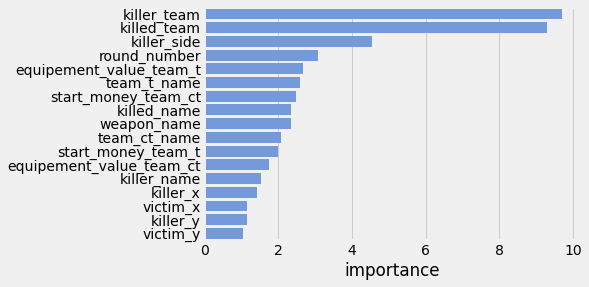

In [67]:
sns.barplot(x=importances.importance, y=importances.index, data=importances, color='cornflowerblue')

### Playground

In [68]:
test_X, test_y = data_transform(data_cleaning(t, MAP_NAME)[0]), data_cleaning(t, MAP_NAME)[1]

In [69]:
playground = test_X.copy()

playground['winner'] = test_y
playground['model'] = xgb.predict(test_X)
playground['win_chance'] = [x[1] for x in xgb.predict_proba(test_X)]

playground = playground.loc[playground['win_chance'] < 0.7]

In [70]:
def map_plot(frame, x, y, color_map, img,s):

    img = plt.imread(img)
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(img)

    plot = ax.scatter(frame[x],frame[y],
              color=['r' if x == 1 else 'b' for x in frame[color_map]],alpha=.5,s=s)
    
    return plot

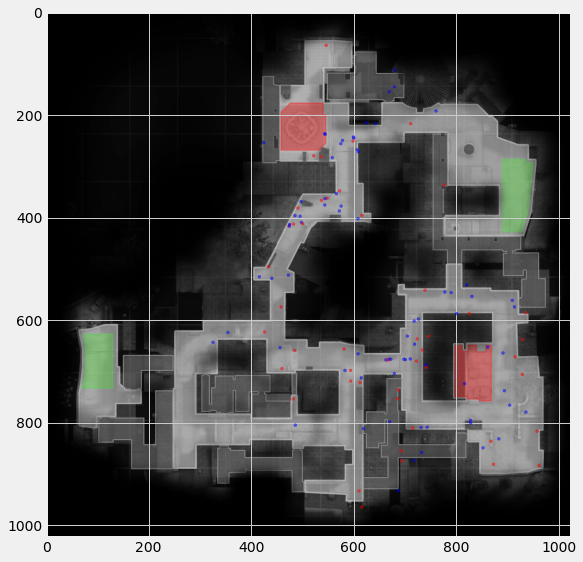

In [71]:
map_plot(playground, 'victim_x', 'victim_y','killed_team',map_render,s=8)                                                                                 

In [73]:
for col in to_transform:
    playground[col] = playground[col].map(inverse_transform[col])

In [74]:
playground.loc[playground['winner'] == playground['model']]

,killer_side,killer_team,killed_side,killed_team,killer_name,killed_name,killer_x,killer_y,round_number,victim_x,...,weapon_name,team_t_name,team_ct_name,equipement_value_team_t,equipement_value_team_ct,start_money_team_t,start_money_team_ct,winner,model,win_chance
47,0,1,1,0,3,5,573.417828,276.706346,8,642.366775,...,8,0,0,23400,20200,21000,13350,1,1,0.642023
50,1,0,0,0,2,9,691.141528,219.451050,8,599.500488,...,9,0,0,23400,20200,21000,13350,1,1,0.687238
51,0,1,1,0,7,7,803.229399,248.546329,8,669.566875,...,8,0,0,23400,20200,21000,13350,1,1,0.681238
52,0,1,1,0,7,6,699.176478,243.678681,8,679.861020,...,8,0,0,23400,20200,21000,13350,1,1,0.660411
65,1,0,0,1,5,2,738.136798,696.678210,11,484.814214,...,9,0,0,25200,26950,34850,18650,0,0,0.199854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0,0,1,0,4,9,433.428727,659.552345,30,741.387796,...,8,1,1,27350,9900,22550,9950,0,0,0.019799
197,1,1,0,0,3,0,748.531612,633.392958,30,710.502865,...,4,1,1,27350,9900,22550,9950,0,0,0.014652
198,0,0,1,1,4,8,706.746953,686.691125,30,746.471174,...,8,1,1,27350,9900,22550,9950,0,0,0.031856
199,1,1,0,0,9,4,811.002076,240.584819,30,760.850297,...,16,1,1,27350,9900,22550,9950,0,0,0.062444


In [78]:
pd.read_csv('data/downloads/furia_games_hltv.csv')

,Match,Maps,Date,Event,Download
0,Isurus vs. FURIA,"Mirage, Overpass, Cache",2017-09-29 00:00:00,Alienware Liga Pro Gamers Club - SEP/17,https://www.hltv.org/download/demo/32643/
1,INTZ vs. FURIA,"Inferno, Cobblestone",2017-09-28 00:00:00,Alienware Liga Pro Gamers Club - SEP/17,https://www.hltv.org/download/demo/32566/
2,TeamOne vs. FURIA,"Mirage, Cobblestone",2017-09-01 00:00:00,Alienware Liga Pro Gamers Club - AUG/17,https://www.hltv.org/download/demo/31626/
3,INTZ vs. FURIA,"Overpass, Cobblestone",2017-08-31 00:00:00,Alienware Liga Pro Gamers Club - AUG/17,https://www.hltv.org/download/demo/31610/
4,FURIA vs. Black Dragons,"Overpass, Cache",2017-08-25 00:00:00,Alienware Liga Pro Gamers Club - AUG/17,https://www.hltv.org/download/demo/31389/
5,Virtus.pro vs. FURIA,"Mirage, Overpass",2021-02-21,IEM Katowice 2021,https://www.hltv.org/download/demo/62463/
6,FaZe vs. FURIA,"Train, Mirage, Overpass",2021-02-21,IEM Katowice 2021,https://www.hltv.org/download/demo/62460/
7,FURIA vs. Natus Vincere,"Mirage, Nuke",2021-02-20,IEM Katowice 2021,https://www.hltv.org/download/demo/62450/
8,FURIA vs. NIP,"Nuke, Overpass",2021-02-19,IEM Katowice 2021,https://www.hltv.org/download/demo/62423/
9,mousesports vs. FURIA,"Inferno, Nuke",2021-01-29,cs_summit 7,https://www.hltv.org/download/demo/62149/


In [77]:
playground[['winner','weapon_name']]

,winner,weapon_name
19,0,8
47,1,8
50,1,9
51,1,8
52,1,8
...,...,...
196,0,8
197,0,4
198,0,8
199,0,16
